This notebook will have an analysis that studies the contribution of individual neuromodulators to the encoding of reward during this task. The data is from the Nucleus Acumbens.

In [1]:

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils


from matplotlib.collections import LineCollection
import pandas as pd

Iterate this for the 4 combinations of 3 NMs

- separate the data into these 4 combinations and use this as input
- The different datasets: 
    - without DA, NE, 5HT, AcH

## Load and format the Neuromodulator (NM) data and behavioural labels

In [2]:
# load the dataframe
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [3]:
# load the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [4]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [5]:
# Combine the traces for all NMs into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

In [6]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [7]:
n_trials = 1765

In [8]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [9]:
np.unique(np.isnan(choice_times),return_counts=True)[1][0]

1717

In [10]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, df = df_trials_ses, trace_times_ = trace_times, choice_times_ = choice_times, window_size=20, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and the next 10 values of the NM data at these indices - 1s window
        n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            trial_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            trial_labels.append(0)


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    trial_labels = np.array(trial_labels)
    print("labels shape: ",trial_labels.shape)

    return nms_HD, trial_labels


In [11]:
all_nms_HD, trial_labels_ = format_data(all_nms)

neural tensor shape:  torch.Size([1717, 80])
labels shape:  (1717,)


## Build and train the model then compute embeddings

In [12]:
max_iterations = 2000

In [13]:
def build_train_compute(neural_data, b_label):


    # build time and behaviour models
    cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10) 

    cebra_behaviour_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    # train them both
    cebra_time_model.fit(neural_data)
    cebra_behaviour_model.fit(neural_data, b_label)

    # compute the embeddings
    time_embedding = cebra_time_model.transform(neural_data)
    behaviour_embedding = cebra_behaviour_model.transform(neural_data)

    # return the embeddings 

    return time_embedding, behaviour_embedding

In [14]:
all_nms_HD.shape

torch.Size([1717, 80])

In [15]:
t_embed_4, b_embed_4 = build_train_compute(all_nms_HD,trial_labels_)

pos:  0.9171 neg:  2.7411 total:  3.6582 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.41it/s]
pos:  0.2862 neg:  5.4648 total:  5.7510 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 38.71it/s]


## Then visualize the embeddings

In [16]:
# divide the labels into rewarded and unrewarded
def define_label_classes(trial_labels = trial_labels_):

    rewarded = trial_labels==1
    unrewarded = trial_labels==0

    rewarded = rewarded.flatten()
    unrewarded = unrewarded.flatten()

    return rewarded, unrewarded

In [17]:
rewarded, unrewarded = define_label_classes()

In [18]:
# view the embeddings

def view(time_embedding, behaviour_embedding, labels, label_classes, title ="Different Angles", size=0.8):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
    ax81.axis('off')
    ax82.axis('off')


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=0.7, title='Time embedding', cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=0.7, title='Time embedding', cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82, markersize=0.7, title='Behaviour embedding', cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82,markersize=0.7, title='Behaviour embedding',  cmap=colours[1])

    gs.tight_layout(figure=fig)

    print("prepaing figure at multiple angles")

    # then view it at multiple angles
    utils.view_embedding(time_embedding, behaviour_embedding,s=size,label=labels,label_class=label_classes, titles=['time embedding','behaviour_embedding'], main_title=title)

prepaing figure at multiple angles


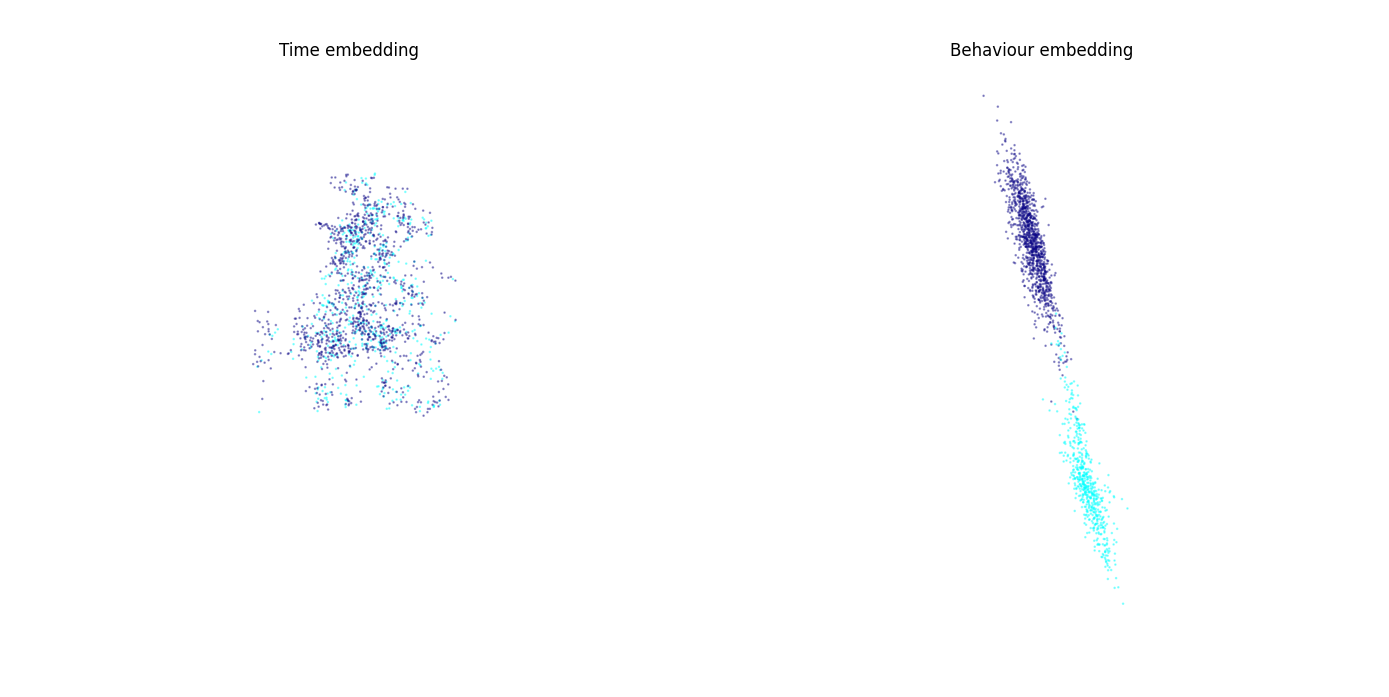

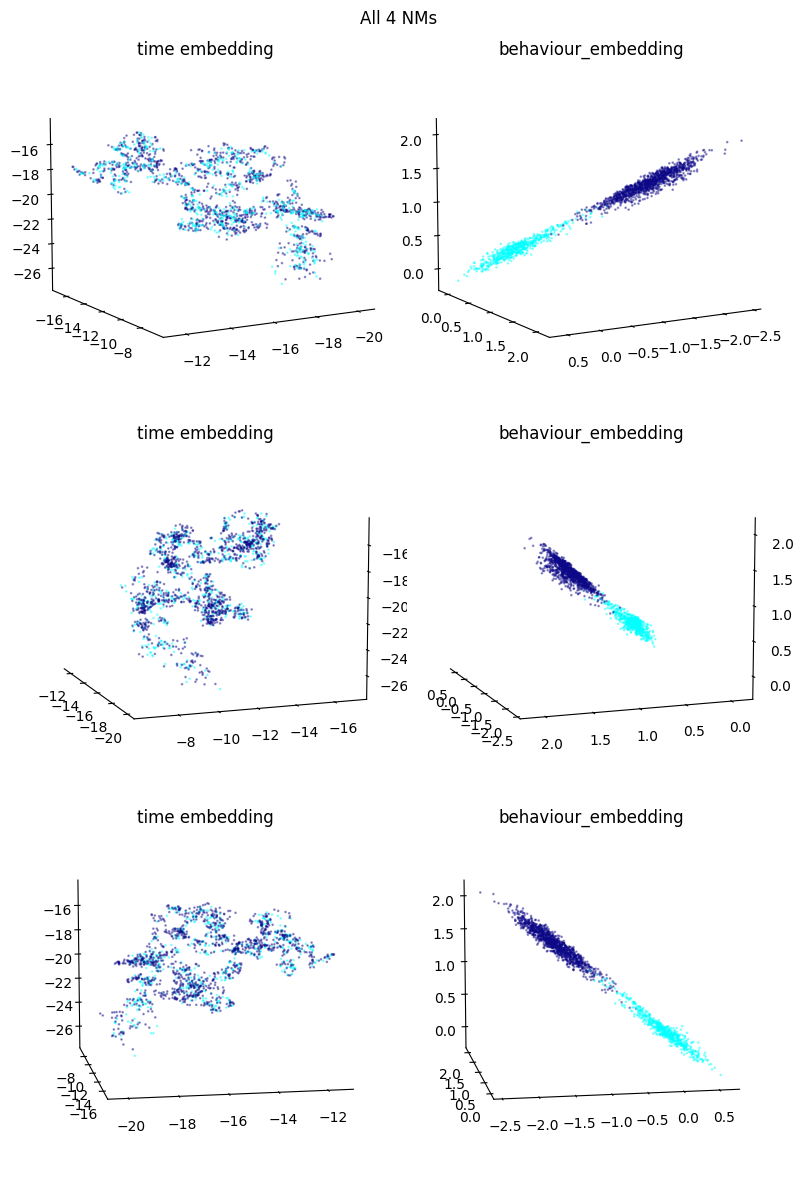

In [19]:
view(t_embed_4, b_embed_4, trial_labels_,label_classes=[rewarded,unrewarded], title="All 4 NMs")

## Analysis of different combinations of Neuromodulators

In [20]:
traces.keys()

dict_keys(['DA NAc', 'NE NAc', '5HT NAc', 'ACh NAc'])

In [21]:
# format the arrays
def create_datasets(traces_=traces):

    # create a list to hold the different combinations of NM data
    datasets = []

    # iterate through the keys in the dictionary holding the NM data
    for key in traces_:

        # at each iteration make an array of NM data and exclude the current NM from the array
        array = np.array([traces_[trace] for trace in traces_.keys() if trace !=key ])

        # format the array 
        f_array = np.transpose(array)
        f_array = f_array.astype(np.float64)
        print("shape of formatted array:", f_array.shape)
        datasets.append(f_array)


    return datasets

In [22]:
datasets = create_datasets()

shape of formatted array: (218572, 3)
shape of formatted array: (218572, 3)
shape of formatted array: (218572, 3)
shape of formatted array: (218572, 3)


In [28]:
# for each NM combination
def nm_analysis(data, missing_nm="" ):

    # format the data into 1s window around the choice and create the labels
    nms_HD, t_labels = format_data(neural_data=data)

    # Build and train the model then compute embeddings
    t_embed, b_embed = build_train_compute(nms_HD, t_labels)

    # define the label classes
    rewarded, unrewarded = define_label_classes(t_labels)

    # view the embeddings
    view(t_embed, b_embed, t_labels,label_classes=[rewarded, unrewarded],title=missing_nm )


    return t_embed, b_embed



### No DA

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  1.0613 neg:  2.9174 total:  3.9787 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 38.10it/s]
pos:  0.2894 neg:  5.4981 total:  5.7875 temperature:  1.0000: 100%|██████████| 2000/2000 [00:54<00:00, 36.44it/s]


prepaing figure at multiple angles


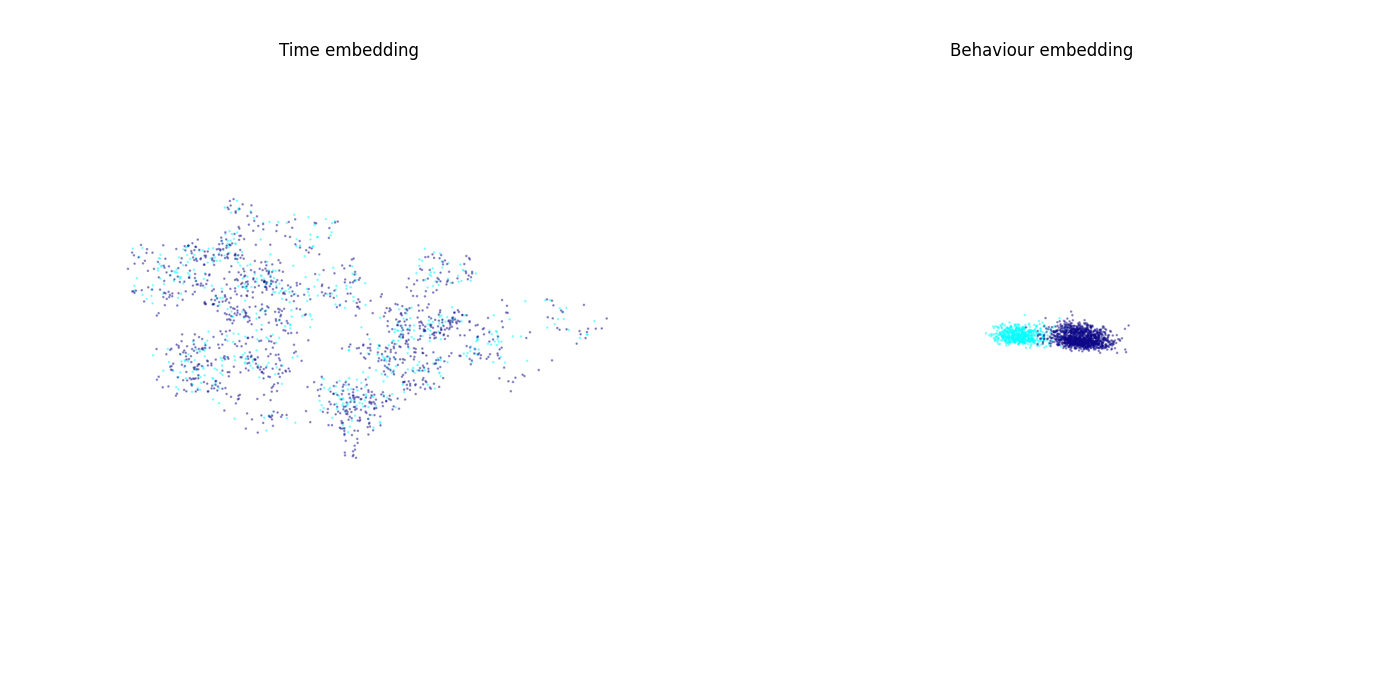

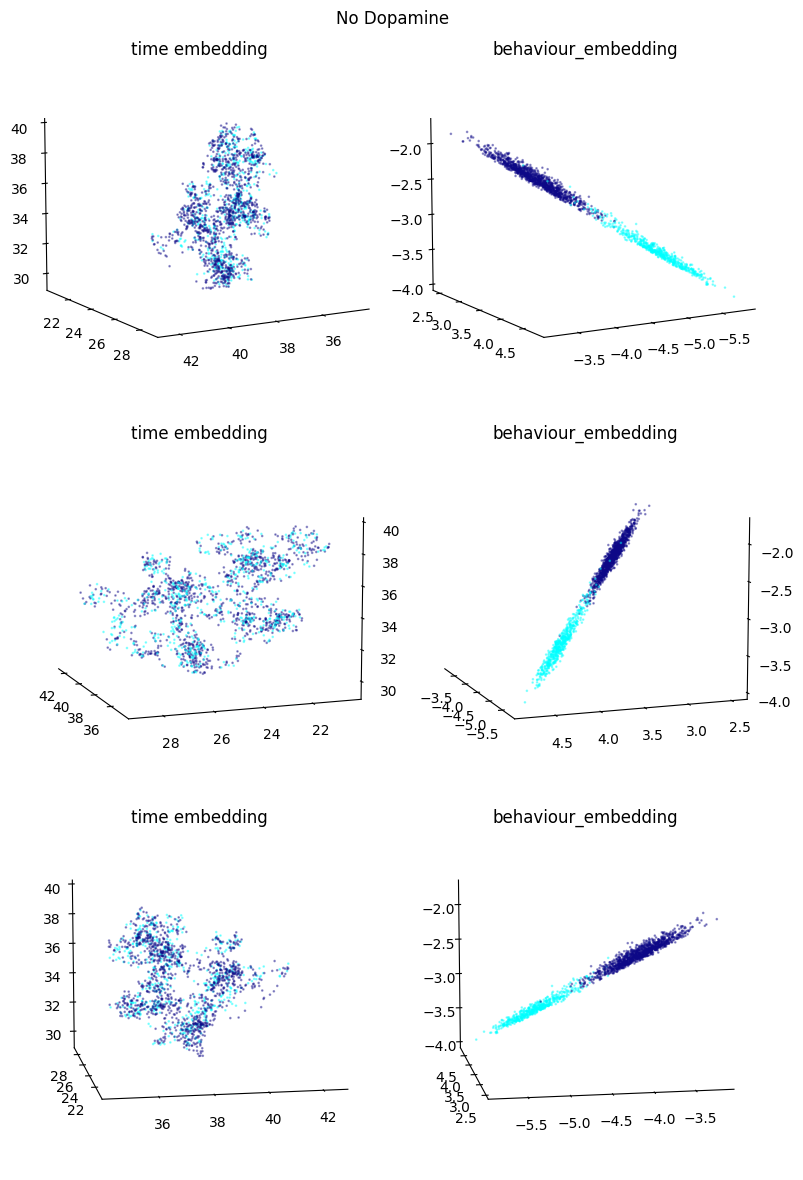

In [29]:
t_embed_nda, b_embed_nda = nm_analysis(datasets[0], "No Dopamine")

No NE

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  0.9764 neg:  2.9579 total:  3.9344 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 37.83it/s]
pos:  0.3335 neg:  5.4984 total:  5.8319 temperature:  1.0000: 100%|██████████| 2000/2000 [00:54<00:00, 36.80it/s]


prepaing figure at multiple angles


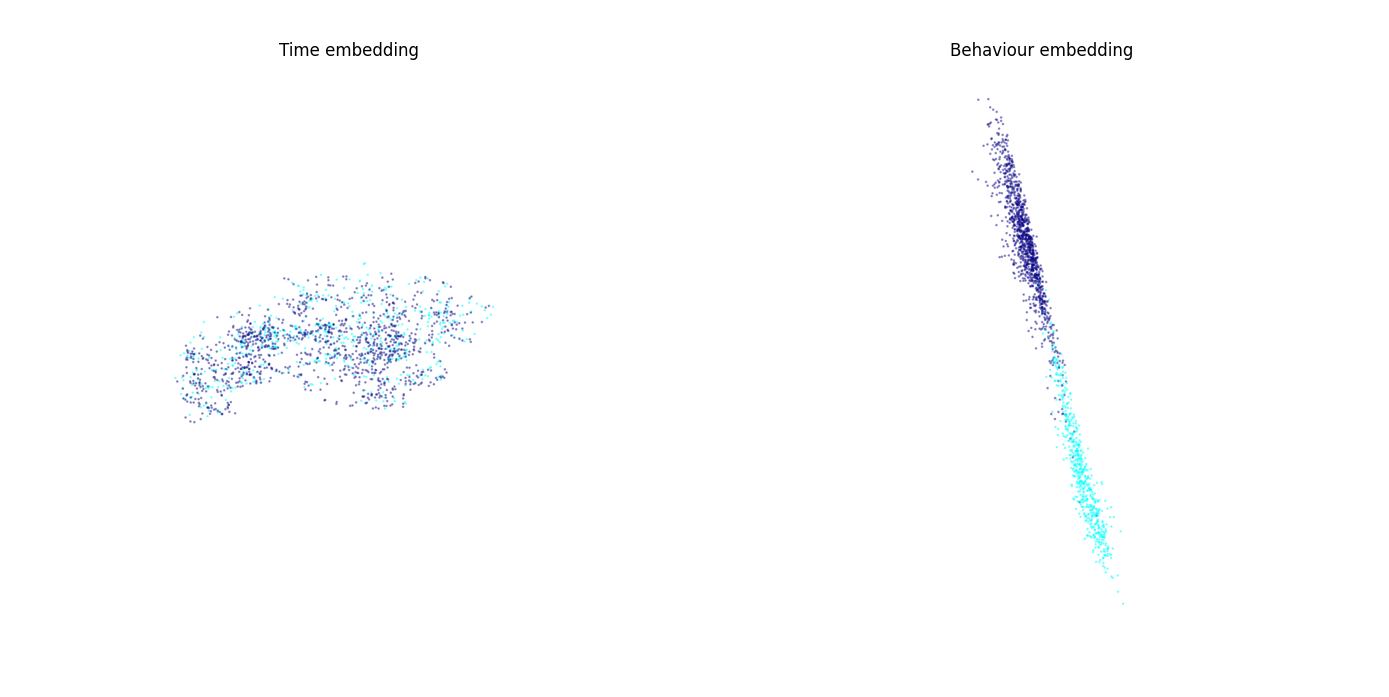

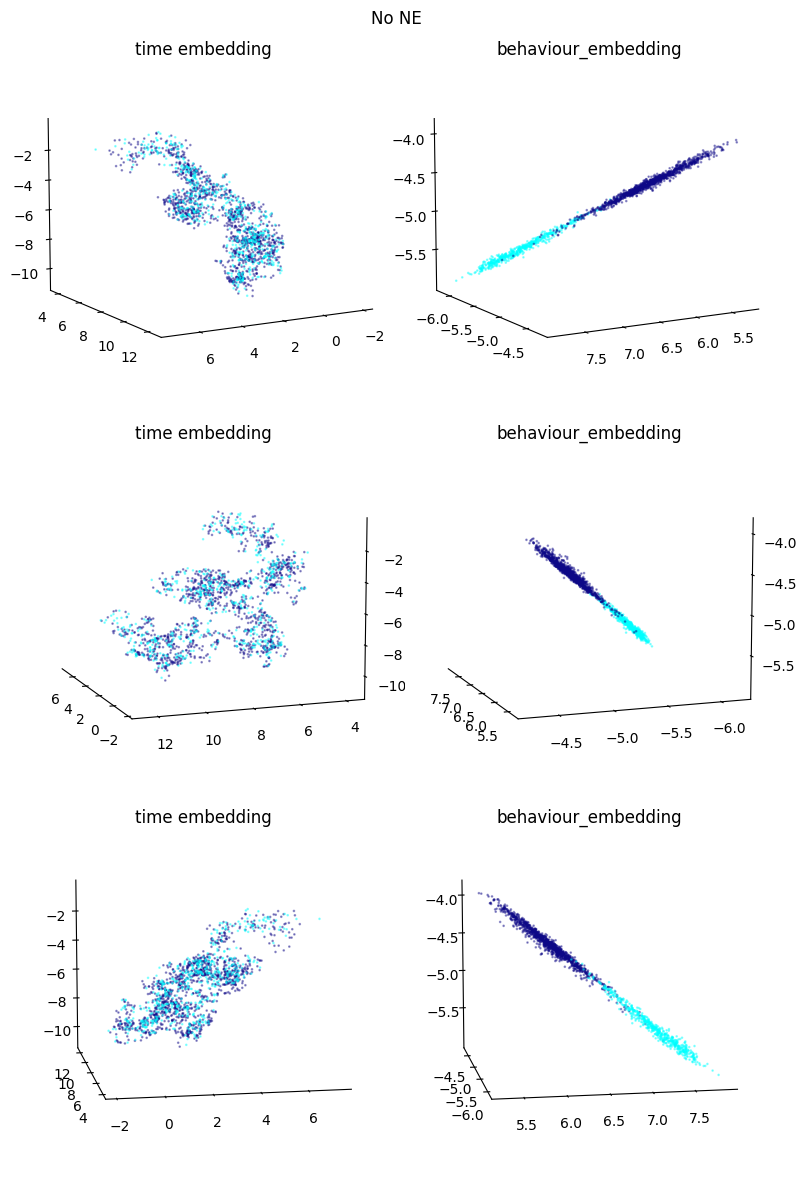

In [30]:
t_embed_nne, b_embed_nne = nm_analysis(datasets[1], "No NE")

No 5HT

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  0.8534 neg:  3.1508 total:  4.0041 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 38.22it/s]
pos:  0.2474 neg:  5.4976 total:  5.7449 temperature:  1.0000: 100%|██████████| 2000/2000 [00:56<00:00, 35.61it/s]


prepaing figure at multiple angles


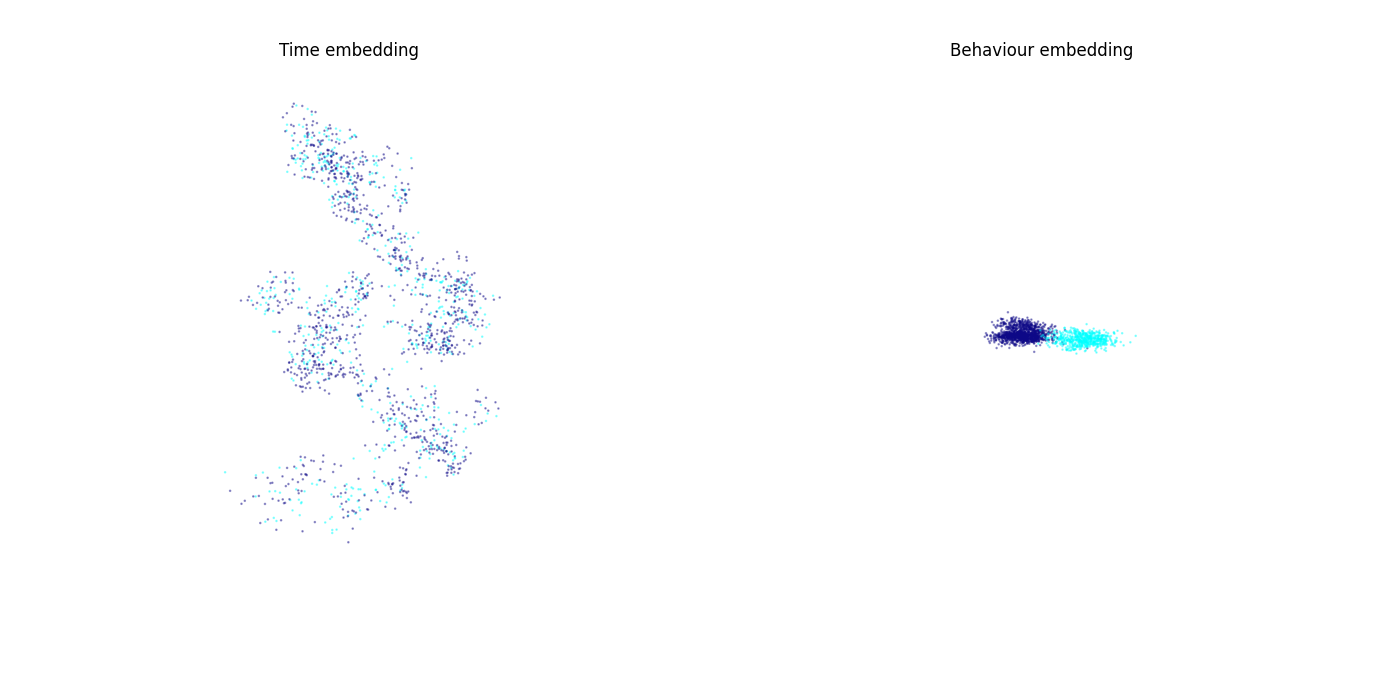

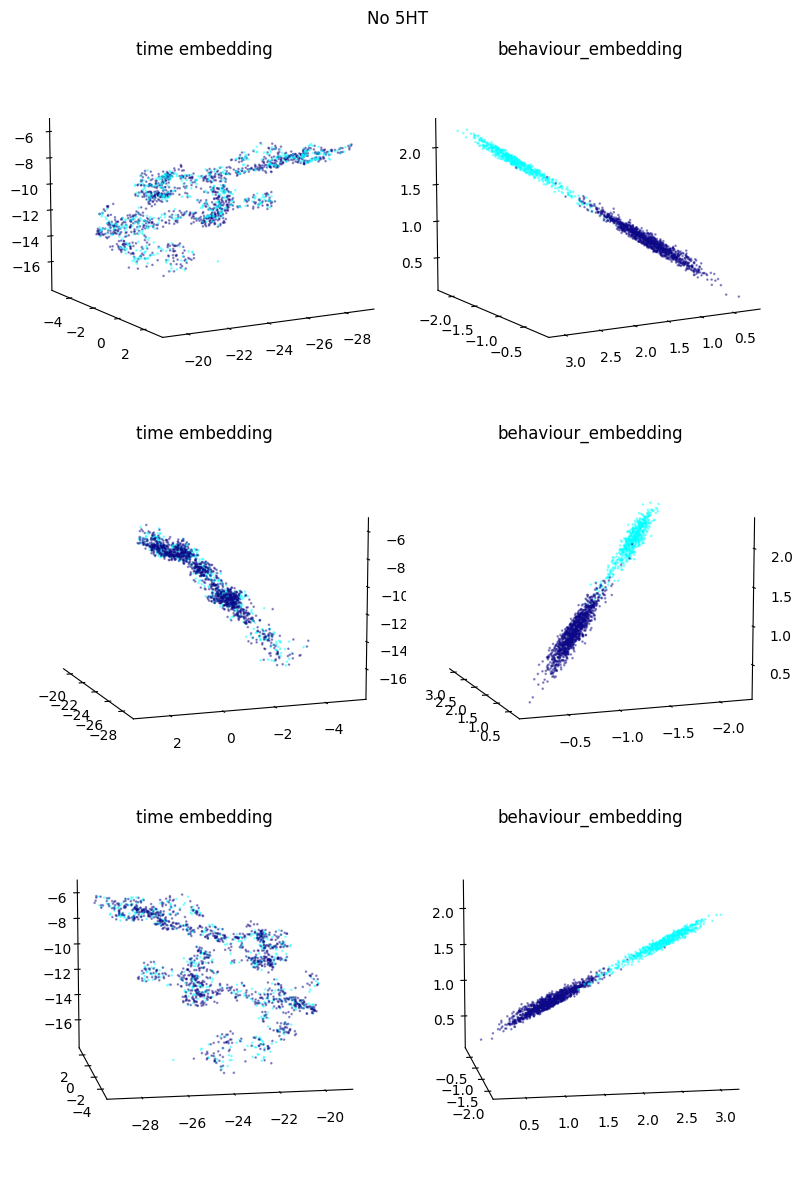

In [31]:
t_embed_nht, b_embed_nht = nm_analysis(datasets[2], "No 5HT")

No ACh

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  0.9811 neg:  3.0643 total:  4.0454 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 38.86it/s]
pos:  0.2686 neg:  5.4657 total:  5.7343 temperature:  1.0000: 100%|██████████| 2000/2000 [00:53<00:00, 37.71it/s]


prepaing figure at multiple angles


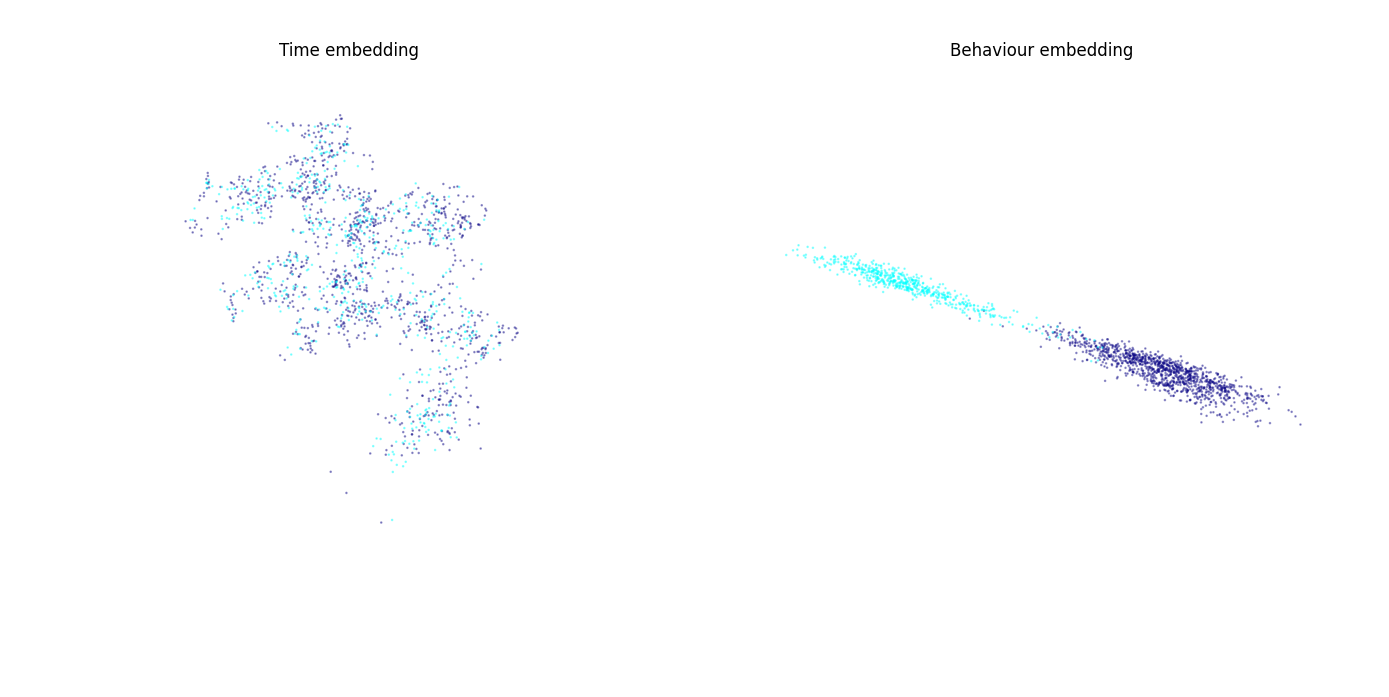

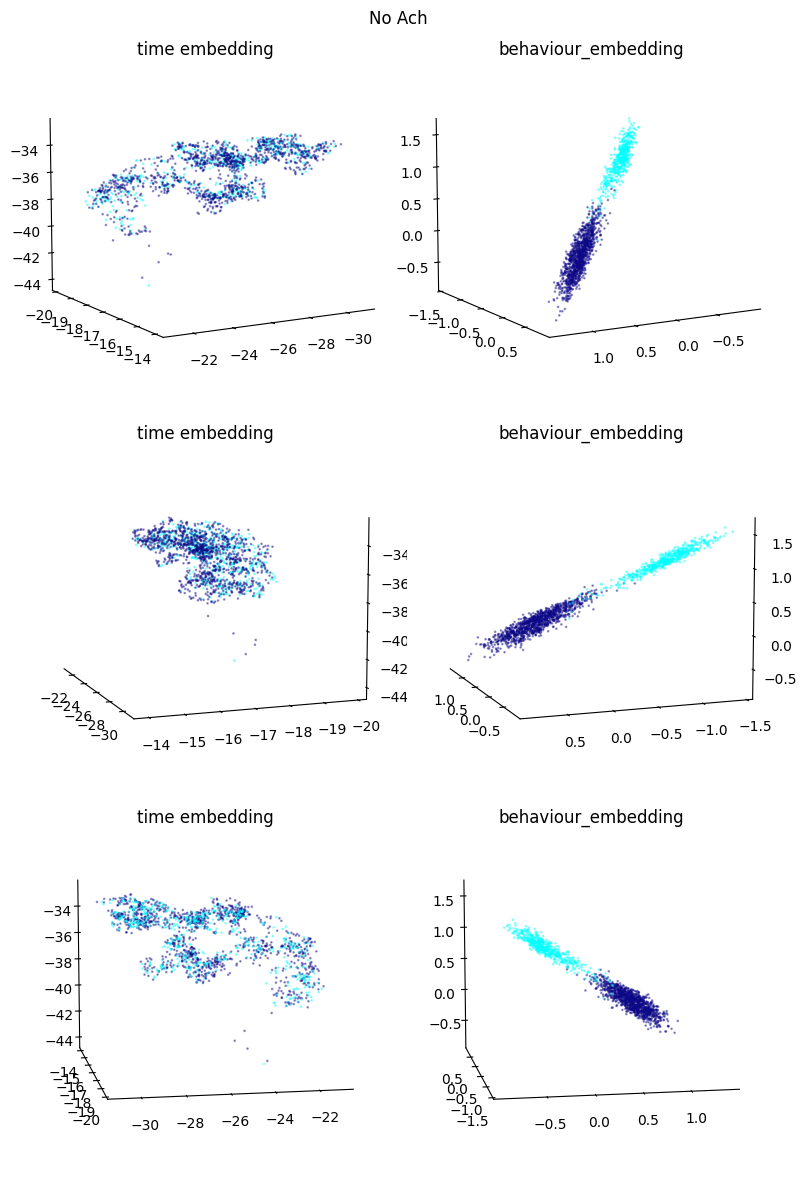

In [37]:
t_embed_nach, b_embed_nach = nm_analysis(datasets[3], "No Ach")

In [38]:
# make list of the embeddings produced
embeddings = [b_embed_nda, b_embed_nne, b_embed_nht, b_embed_nach]

In [39]:
n_plots = len(embeddings)

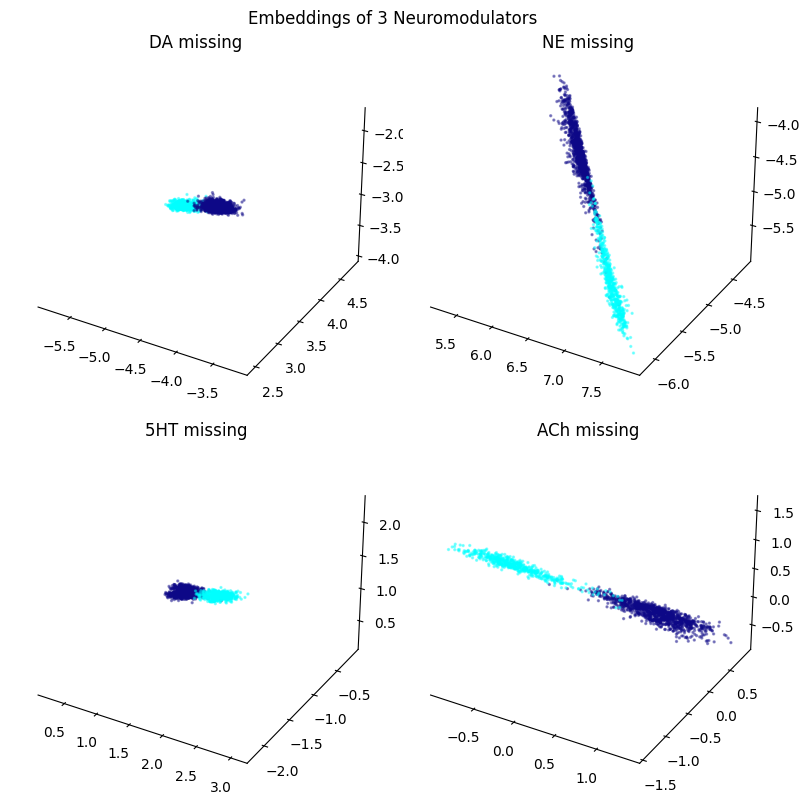

In [45]:
# plot the behaviour embeddings together for all combinations
fig = plt.figure(figsize=(8,4*n_plots))
gs = gridspec.GridSpec(n_plots, 2, figure=fig)

c = ['cool','plasma','pink','winter']
titles = ['DA missing', 'NE missing', '5HT missing', 'ACh missing']

for i, embed in enumerate(embeddings):

    # create the axes
    ax1 = fig.add_subplot(gs[i // 2, i%2], projection='3d')

    # plot the embedding
    cebra.plot_embedding(embedding=embed[rewarded,:], embedding_labels=trial_labels_[rewarded], ax=ax1, markersize=2,title=titles[i], cmap=c[0])
    cebra.plot_embedding(embedding=embed[unrewarded,:], embedding_labels=trial_labels_[unrewarded], ax=ax1, markersize=2,title=titles[i], cmap=c[1])

plt.suptitle("Embeddings of 3 Neuromodulators")
plt.tight_layout()


Later: test how well the CEBRA models are doing i.e. plot the loss and other model parameters